# Long post sysrem analysis

Multiple nights of 802/NG2000 data have been collected into a single file, and sysrem has been run on the main flux array.

* Does the detrending perform better?
* Do the noise properties improve?

In [127]:
%matplotlib inline

import fitsio
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import sigma_clip
from scipy.stats import binned_statistic
import seaborn as sns
import sys
sys.path.insert(0, '..')
from binmodule import fast_bin
from gatspy.periodic import LombScargleFast

sns.set(style='ticks', context='poster', palette='Set2')
colours = sns.color_palette()

In [24]:
fname = '/home/sw/work/NGTS/pipeline/ZLP/sysrem/tamout.fits'
catname = '../ng2000-matched-catalogue.fits'

In [133]:
with fitsio.FITS(fname) as infile:
    tamflux = infile['flux'].read()
    hjd = infile['hjd'].read()
    imagelist = infile['imagelist'].read()

In [25]:
cat = fitsio.read(catname, 1)
rmag = cat['r1mag_ppmxl']

In [20]:
unique_nights = np.unique(imagelist['NIGHT'])
unique_nights

array([b'20150829', b'20150831', b'20150901', b'20150902', b'20150903',
       b'20150904', b'20150905', b'20150906', b'20150909', b'20150911',
       b'20150913', b'20150914', b'20150915', b'20150917', b'20150919'], 
      dtype='|S8')

In [63]:
ind = np.where((imagelist['NIGHT'] == b'20150909'))[0]
sample = tamflux[:, ind]
# sample = tamflux

In [64]:
sample.shape

(18910, 28509)

In [65]:
sc = sigma_clip(sample, axis=1)

In [106]:
def mad(data, precomputed_median=None, axis=None):
    if precomputed_median is not None:
        median = precomputed_median
    else:
        median = np.median(data, axis=axis)
    median = np.atleast_2d(median)
    d = np.atleast_2d(data)
    return np.median(np.abs(data - median.T), axis=axis)    

In [111]:
def std(*args, **kwargs):
    return 1.48 * mad(*args, **kwargs)

In [112]:
def compute_stats(data):
    med_flux = np.median(data, axis=1)
    std_flux = std(data, precomputed_median=med_flux, axis=1)
    frms = std_flux / med_flux
    return med_flux, frms

In [113]:
_, frms = compute_stats(sc)

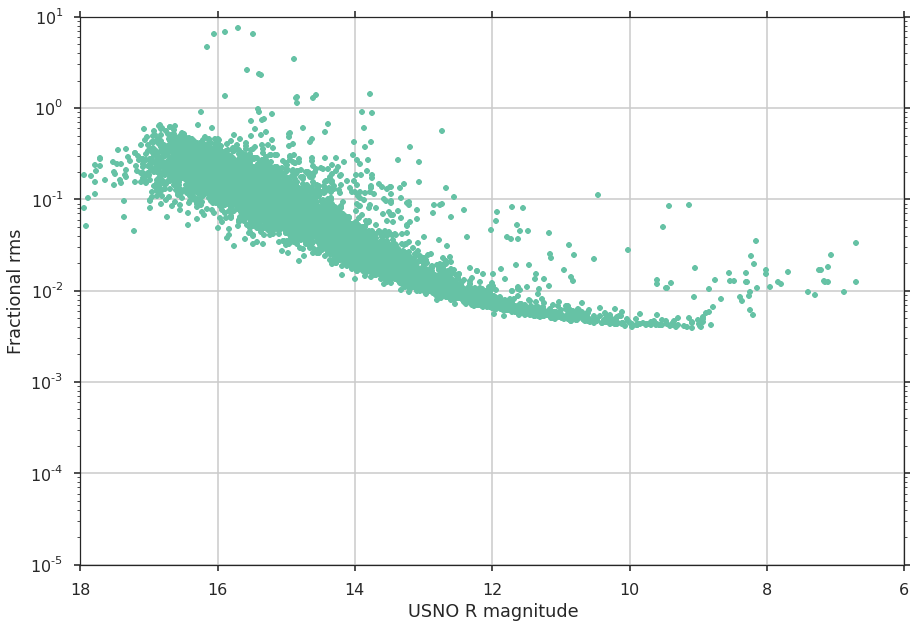

In [114]:
fig, axis = plt.subplots()
axis.semilogy(rmag, frms, '.')
axis.grid(True)
axis.set(xlim=(18, 6), ylim=(1E-5, 1E1), xlabel='USNO R magnitude', ylabel='Fractional rms')
fig.tight_layout()

In [138]:
bin_values = np.unique(np.logspace(0, np.log10(100 * 60 / 10), 5).astype(int))
print('Bin values: %s' % bin_values)

Bin values: [  1   4  24 121 599]


''

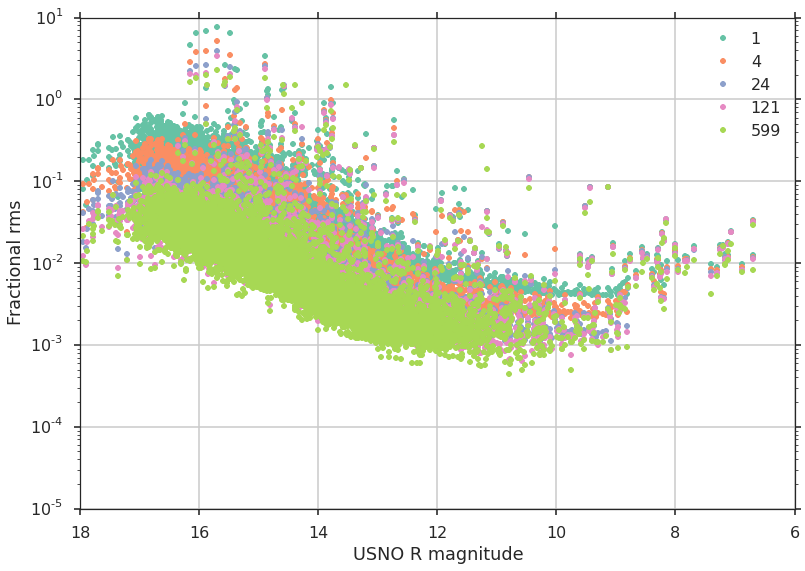

In [139]:
fig, axis = plt.subplots()
for bin_value in bin_values:
    binned = fast_bin(sc, bin_value)
    _, frms_binned = compute_stats(binned)
    axis.semilogy(rmag, frms_binned, '.', label=bin_value)
axis.legend(loc='best')
axis.set(xlim=(18, 6), ylim=(1E-5, 1E1), xlabel='USNO R magnitude', ylabel='Fractional rms')
axis.grid(True)
;

In [163]:
bin_15m = fast_bin(sc, 90)
_, frms_15m = compute_stats(bin_15m)
ind = np.where((rmag < 11) & (rmag > 10) & (frms_15m < 1E-3))[0]
chosen = int(np.random.choice(ind, replace=False, size=1))
print('Studying lightcurve %d' % chosen)

Studying lightcurve 2335


In [164]:
lc = bin_15m[chosen]
lc_sc = sigma_clip(lc)

(70442.698437500003, 71055.395312499997)

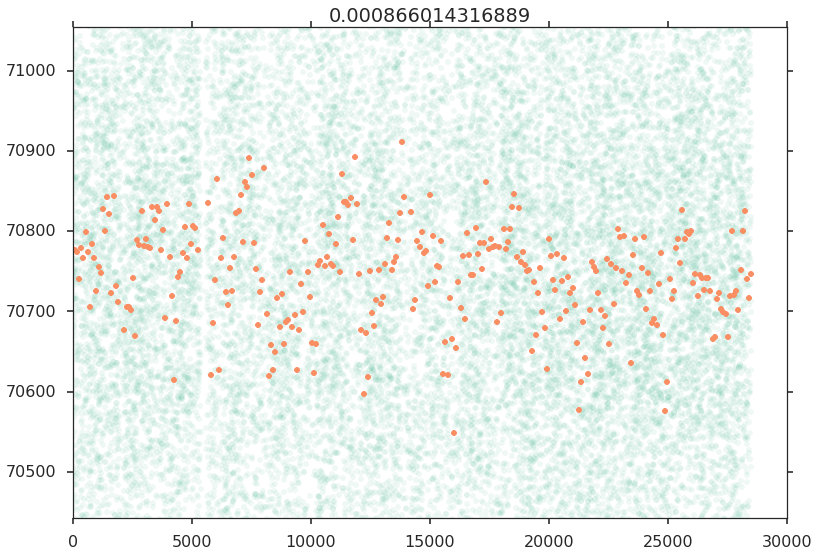

In [171]:
plt.plot(np.arange(tamflux.shape[1]), tamflux[chosen], '.', alpha=0.1)
plt.plot(np.linspace(0, tamflux.shape[1], lc_sc.size), lc_sc, '.')
plt.title(std(lc_sc) / np.median(lc_sc))
plt.ylim(np.median(lc_sc) - 5 * std(lc_sc), np.median(lc_sc) + 5 * std(lc_sc))

In [172]:
model = LombScargleFast(fit_period=True)
model.optimizer.set(quiet=False, period_range=(0.01, 10))
model.fit(hjd[chosen], tamflux[chosen])

Finding optimal frequency:
 - Estimated peak width = 0.296
 - Using 5 steps per peak; omega_step = 0.0591
 - User-specified period range:  0.01 to 10
 - Computing periods at 10616 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


In [177]:
print('Best period: %f days' % model.best_period)

Best period: 0.403741 days


In [173]:
periods = np.logspace(-2, 1, 1000)
power = model.periodogram(periods)

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/gatspy/periodic/lomb_scargle_fast.py:420: UserWarning: The score() method defaults to a slower O[N^2] algorithm. Use the score_frequency_grid() method to access the fast FFT-based algorithm
  warnings.warn("The score() method defaults to a slower O[N^2] "


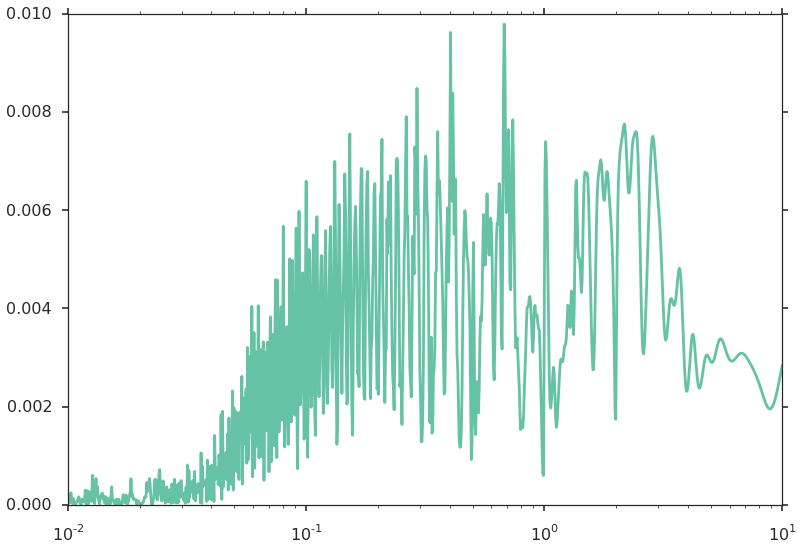

In [174]:
plt.semilogx(periods, power)

In [178]:
phase = (hjd[chosen] / model.best_period) % 1

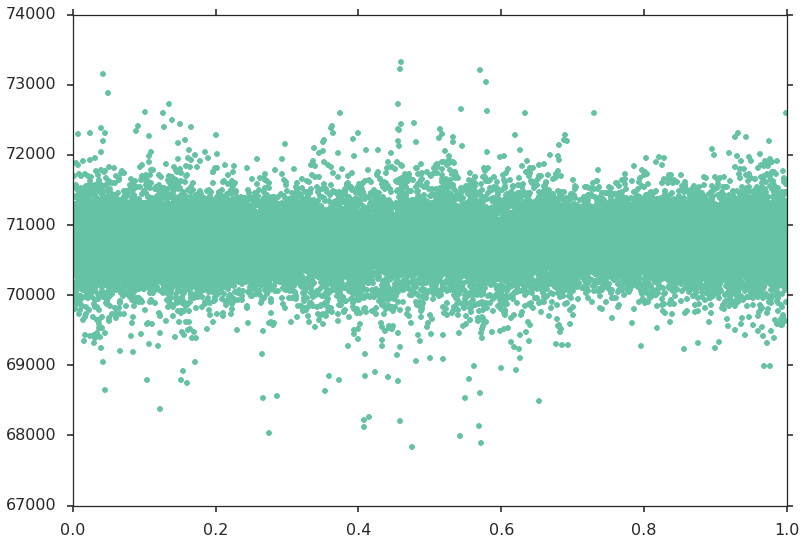

In [181]:
plt.plot(phase, sigma_clip(tamflux[chosen]), '.')

Looking at a single night

In [182]:
night = b'20150909'

In [188]:
ind = np.where((imagelist['NIGHT'] == night))[0]
sample_single = tamflux[:, ind]
print(sample_single.shape)
sc_single = sigma_clip(sample_single, axis=1)

(18910, 1885)


In [186]:
_, frms_single = compute_stats(sc_single)

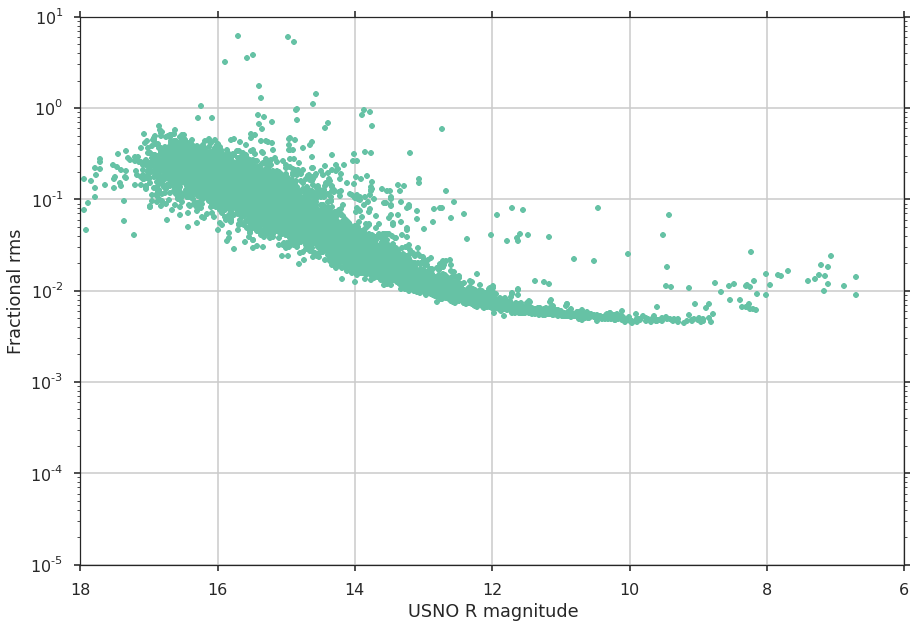

In [187]:
fig, axis = plt.subplots()
axis.semilogy(rmag, frms_single, '.')
axis.grid(True)
axis.set(xlim=(18, 6), ylim=(1E-5, 1E1), xlabel='USNO R magnitude', ylabel='Fractional rms')
fig.tight_layout()

''

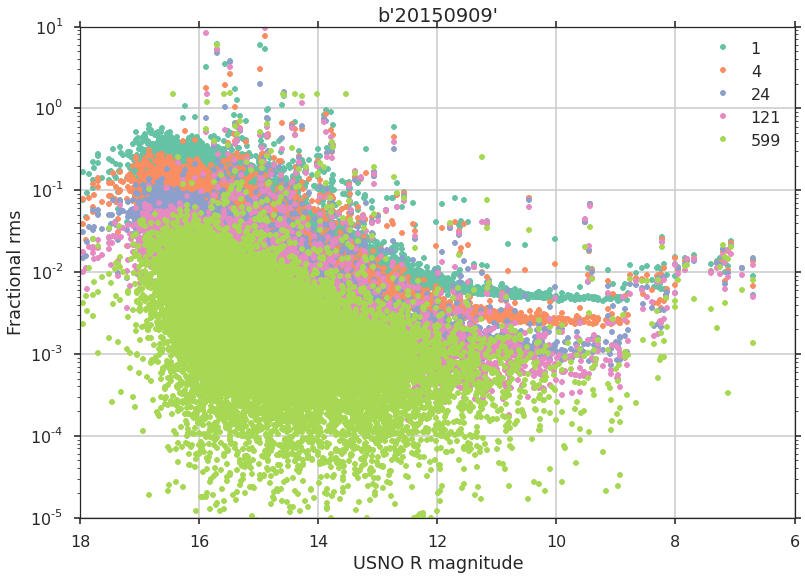

In [189]:
fig, axis = plt.subplots()
for bin_value in bin_values:
    binned = fast_bin(sc_single, bin_value)
    _, frms_binned = compute_stats(binned)
    axis.semilogy(rmag, frms_binned, '.', label=bin_value)
axis.legend(loc='best')
axis.set(xlim=(18, 6), ylim=(1E-5, 1E1), xlabel='USNO R magnitude', ylabel='Fractional rms', title=night)
axis.grid(True)
;

I'm sure this is better than the single night performance. Try with that.

In [192]:
fname_singledet = '/ngts/pipedev/ParanalOutput/nightly_data/20150909-ng2000-802-custom-flat-high-quality.fits'
with fitsio.FITS(fname_single) as infile:
    tamflux_singledet = infile['tamflux'].read()
sc_singledet = sigma_clip(tamflux_singledet, axis=1)

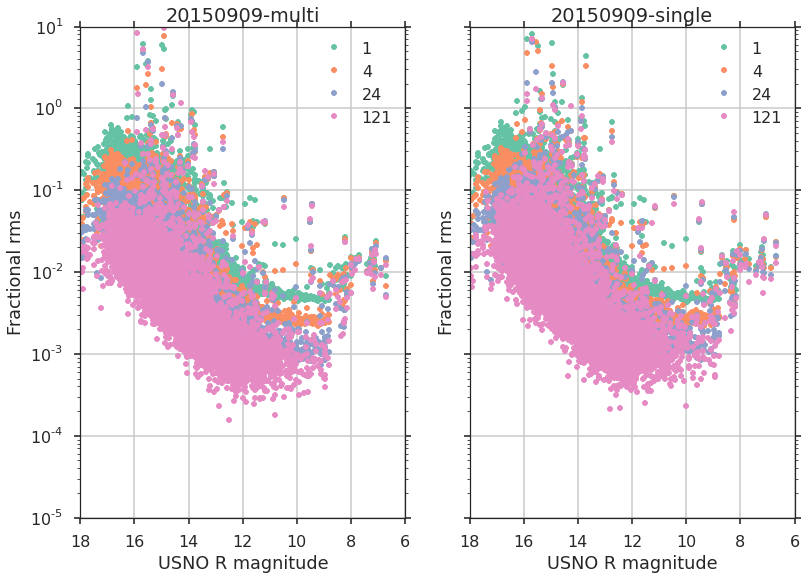

In [198]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
# Ignore the last bin for now is it's too noisy
for bin_value in bin_values[:-1]:
    for (dataset, axis) in zip([sc_single, sc_singledet], axes):
        binned = fast_bin(dataset, bin_value)
        _, frms_binned = compute_stats(binned)
        axis.semilogy(rmag, frms_binned, '.', label=bin_value)
        
for axis, title in zip(axes, ['20150909-multi', '20150909-single']):
    axis.legend(loc='best')
    axis.set(xlim=(18, 6), ylim=(1E-5, 1E1), xlabel='USNO R magnitude', ylabel='Fractional rms', title=title)
    axis.grid(True)
    ;

''

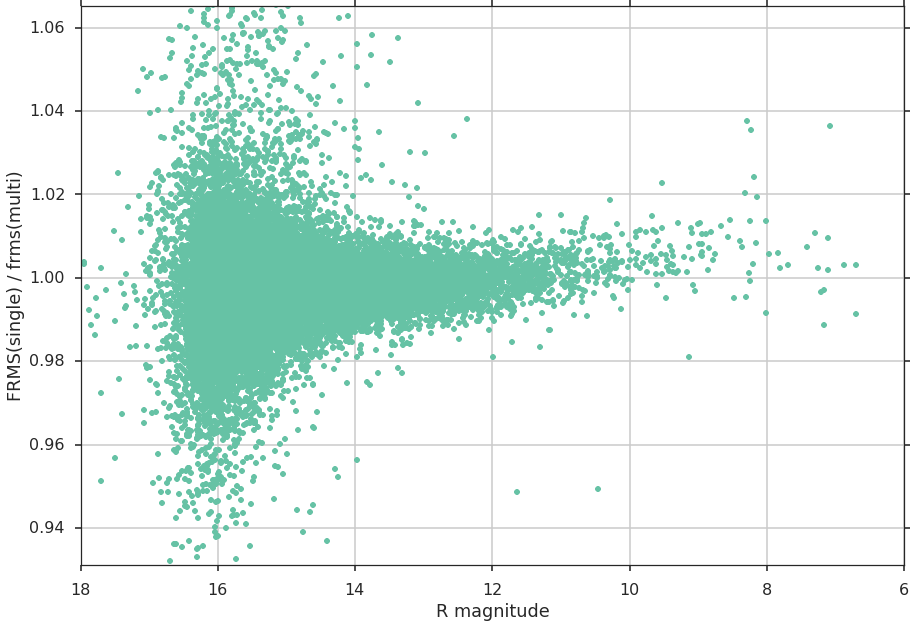

In [226]:
bin_value = 250
binned_single, binned_multi = [fast_bin(d, bin_value) for d in [sc_singledet, sc_single]]
frms_single, frms_multi = [compute_stats(b)[0] for b in [binned_single, binned_multi]]
ind = (frms_single > 0) & (frms_multi > 0)
ratio = frms_single[ind] / frms_multi[ind]
ratio_sc = sigma_clip(ratio, iters=5)

fig, axis = plt.subplots()
axis.plot(rmag[ind], ratio, '.')
axis.set(ylim=(ratio_sc.mean() - 5. * ratio_sc.std(), ratio_sc.mean() + 5. * ratio_sc.std()),
        xlabel='R magnitude', xlim=(18, 6), ylabel='FRMS(single) / frms(multi)')
axis.grid(True)
fig.tight_layout()
;